In [12]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


## Importing Dataset

In [13]:

!git clone https://github.com/pantherofficial404/Image-Voice-Captioning---Keras.git
!ls

Cloning into 'Image-Voice-Captioning---Keras'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 1), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
Image-Voice-Captioning---Keras	oauth-030a59d2bab0.json  sample_data


In [14]:
!git clone https://github.com/wikiabhi/image-caption-generator.git

Cloning into 'image-caption-generator'...
remote: Enumerating objects: 8114, done.
remote: Counting objects: 100% (8114/8114), done.
remote: Compressing objects: 100% (8111/8111), done.
remote: Total 8114 (delta 5), reused 8112 (delta 3), pack-reused 0
Receiving objects: 100% (8114/8114), 1.03 GiB | 16.64 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (8106/8106), done.


In [0]:
# Load File Helper Function
def loadFile(filename):
  with open(filename,"r") as file:
    data = file.read()
    
  return data

In [0]:
textData = loadFile("Image-Voice-Captioning---Keras/Dataset/Flickr8k.token.txt")

In [0]:
# Image to description Maping Helper Function
def descriptionMapper(textData):
  imageDescriptionMapper = {}
  for line in textData.split("\n"):
    lineContainer = line.split("\t")
    if(len(line)<2):
      continue
    imageId,imageDescription = lineContainer[0],lineContainer[1:]
    imageName = imageId.split(".")[0] 
    imageDescription = " ".join(imageDescription)
    if imageName not in imageDescriptionMapper:
      imageDescriptionMapper[imageName] = []
    imageDescriptionMapper[imageName].append(imageDescription)
    
  return imageDescriptionMapper

In [0]:
imageDescriptionMapper = descriptionMapper(textData)

In [19]:
imageDescriptionMapper["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
def cleanDescription(description):
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in description.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      desc = desc.split()
      desc = [word.lower() for word in desc]
      desc = [w.translate(table) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      desc_list[i] =  ' '.join(desc)

In [0]:
cleanDescription(imageDescriptionMapper)

In [0]:
def vocabularyConverter(descriptions):
  vocabulary = set()
  for imageId,_ in descriptions.items():
    [vocabulary.update(d.split()) for d in descriptions[imageId]]
  return vocabulary

In [0]:
vocab = vocabularyConverter(imageDescriptionMapper)

In [0]:
def saveDescription(imageDescriptionMapper,filename):
  
  lines = list()
  
  for imageId,descriptions in imageDescriptionMapper.items():
    
    for description in descriptions:
      lines.append(imageId +" "+ description)
      
    data = "\n".join(lines)
    
    with open(filename,"w") as file:
      file.write(data)
      

In [0]:
saveDescription(imageDescriptionMapper,'description.txt')

In [0]:
def loadImageId(filePath):
  data = loadFile(filePath)
  imageIds = []
  
  for line in data.split("\n"):
    if(len(line)<2):
      continue
    imageId = line.split(".")[0]
    imageIds.append(imageId)
  return set(imageIds)

In [0]:
trainImageIds = loadImageId("Image-Voice-Captioning---Keras/Dataset/Flickr_8k.trainImages.txt")

In [0]:
description = loadFile("description.txt")
images = []
def loadImageNames():
  for line in description.split("\n"):
    images.append(line.split(" ")[0]+".jpg")
  return set(images)
  
  
imageNames = loadImageNames()

In [0]:
def getImageIds(filePath):
  return [word.split(".")[0] for word in open(filePath, 'r').read().strip().split('\n')]

In [0]:
trainImageIds = getImageIds("Image-Voice-Captioning---Keras/Dataset/Flickr_8k.trainImages.txt")

In [0]:
testImageIds = getImageIds("Image-Voice-Captioning---Keras/Dataset/Flickr_8k.testImages.txt")

In [0]:
def loadCleanDescription(filePath,imageIds):
  file = loadFile(filePath)
  descriptions = {}
  
  for line in file.split("\n"):
    
    sentence = line.split(" ")
    imageId,desc = sentence[0],sentence[1:]
    
    
    if imageId in imageIds:
      if imageId not in descriptions:
        descriptions[imageId] = []
      descriptions[imageId].append("startseq "+" ".join(desc)+" endseq")
      
  return descriptions
  

In [0]:
trainImageDescription = loadCleanDescription("description.txt",trainImageIds)

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [35]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

W0616 15:07:14.966245 140139490953088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 15:07:15.012806 140139490953088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 15:07:15.036829 140139490953088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 15:07:15.081149 140139490953088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 15:07:15.082117 1401394909

96116736/96112376 [==============================] - 7s 0us/step


In [0]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [37]:
trainImageFeature = {}
counter = 0
for imageId in trainImageIds:
  trainImageFeature[imageId] = encode("image-caption-generator/data/Flicker8k_Dataset/"+imageId+".jpg")
  print(counter)
  counter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
testImageFeature = {}
for imageId in testImageIds:
  testImageFeature[imageId] = encode("image-caption-generator/data/Flicker8k_Dataset/"+imageId+".jpg")

In [0]:
trainDescription = []

for imageIds,descriptions in trainImageDescription.items():
  for description in descriptions:
    trainDescription.append(description)

In [40]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in trainDescription:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [42]:
vocab_size = len(ixtoword) + 1
vocab_size

1652

In [43]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(trainImageDescription)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
import requests,zipfile,io
r = requests.get("http://nlp.stanford.edu/data/glove.6B.zip")

In [0]:
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [0]:
def generator(imageDescription,imageFeatures,wordToIndex,maxLength,batchSize):
  x1,x2,y = [],[],[]
  n = 0
  
  while 1:
    for imageIds,descriptions in imageDescription.items():
      n += 1
      
      imageFeature = imageFeatures[imageIds]
      
      for description in descriptions:
        sequence = [wordToIndex[word] for word in description.split(" ") if word in wordToIndex]
        
        for i in range(1,len(sequence)):
          inputSequence,outputSequence = sequence[:i],sequence[i]
          inputSequence = pad_sequences([inputSequence],maxlen=maxLength)[0]
          outputSequence = to_categorical([outputSequence],num_classes=vocab_size)[0]
          x1.append(imageFeature)
          x2.append(inputSequence)
          y.append(outputSequence)
        if n == batchSize:
          yield [[array(x1),array(x2)],array(y)]
          x1,x2,y = [],[],[]
          n = 0

In [47]:
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [49]:
embedding_matrix.shape

(1652, 200)

In [50]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

W0616 15:11:02.515095 140139490953088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0616 15:11:02.863445 140139490953088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


W0616 15:11:04.203139 140139490953088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(trainImageDescription)//number_pics_per_bath

In [64]:
for i in range(epochs):
    generatorOutput = generator(trainImageDescription, trainImageFeature, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generatorOutput, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.8338
Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.8222
Epoch 1/1
1000/1000 [==============================] - 75s 75ms/step - loss: 2.8091
Epoch 1/1
1000/1000 [==============================] - 75s 75ms/step - loss: 2.7958
Epoch 1/1
1000/1000 [==============================] - 75s 75ms/step - loss: 2.7852
Epoch 1/1
1000/1000 [==============================] - 75s 75ms/step - loss: 2.7691
Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.7565
Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.7444
Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.7313
Epoch 1/1
1000/1000 [==============================] - 76s 76ms/step - loss: 2.7232


In [0]:
def modelPrediction(imageId):
  inputText = "startseq"
  imageFeature = testImageFeature[imageId].reshape((1,2048))
  for i in range(max_length):
    sequence = [wordtoix[word] for word in inputText.split() if word in wordtoix]
    sequence = pad_sequences([sequence],maxlen=max_length)
    prediction = model.predict([imageFeature,sequence],verbose=0)
    prediction = np.argmax(prediction)
    word = ixtoword[prediction]
    inputText += " " + word
    if word == "endseq":
      break
  finalResult = inputText.split()
  finalResult = finalResult[1:-1]
  finalResult = " ".join(finalResult)
  return finalResult

In [66]:
testImageIds[:10]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0']

In [0]:
def getImagePath(imageId):
  return "image-caption-generator/data/Flicker8k_Dataset/{}.jpg".format(imageId)

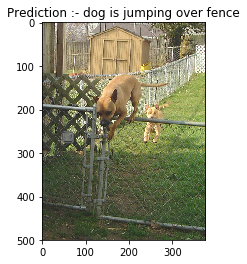

In [119]:
from IPython.display import Audio
from gtts import gTTS
testImageId = testImageIds[np.random.randint(len(testImageIds))]
imagePath = getImagePath(testImageId)
img = plt.imread(imagePath)
plt.imshow(img)
plt.title("Prediction :- "+modelPrediction(testImageId))
plt.show()
mytext = modelPrediction(testImageId)
language = 'en'
myobj = gTTS(text=mytext, lang=language, slow=False) 
myobj.save("prediction.mp3") 
Audio("prediction.mp3",autoplay=True)

In [0]:
model.save_weights("model.h5")